In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile

#读取文件
with ZipFile('airbnb.zip') as z:
    csv_files = [f for f in z.namelist() if f.endswith('.csv')]
    df_list = []
    for f in csv_files:
        with z.open(f) as file:
            df_list.append(pd.read_csv(file))
df = pd.concat(df_list, ignore_index=True)
print(f"合并后的 DataFrame 大小: {df.shape}")

合并后的 DataFrame 大小: (429541, 18)


# section01 空值异常值

In [11]:
# 2. 空值检查
null_counts = df.isnull().sum().sort_values(ascending=False)
print("\n各列空值数量：")
print(null_counts)


各列空值数量：
license                           377676
price                             146933
reviews_per_month                 126341
last_review                       126341
number_of_reviews_ltm              48895
host_name                             72
name                                  34
id                                     0
neighbourhood_group                    0
host_id                                0
room_type                              0
longitude                              0
latitude                               0
neighbourhood                          0
minimum_nights                         0
number_of_reviews                      0
availability_365                       0
calculated_host_listings_count         0
dtype: int64


In [12]:
# 3. 处理空值
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce') #上次浏览全部转换成日期 如果为空 则标注nat

In [13]:
# 4. 异常值过滤：价格保留在 1–1000
df = df[(df['price'] > 0) & (df['price'] <= 1000)]
print(f"\n过滤后 DataFrame 大小: {df.shape}")


过滤后 DataFrame 大小: (279304, 18)


In [14]:
# 5. 创建特征
df['log_price'] = np.log(df['price'])
today = pd.to_datetime('2025-06-21')
df['days_since_last_review'] = (today - df['last_review']).dt.days
df['availability_rate'] = df['availability_365'] / 365
df['avg_reviews_per_listing'] = df['number_of_reviews'] / df['calculated_host_listings_count']#房东每个房子的评论数

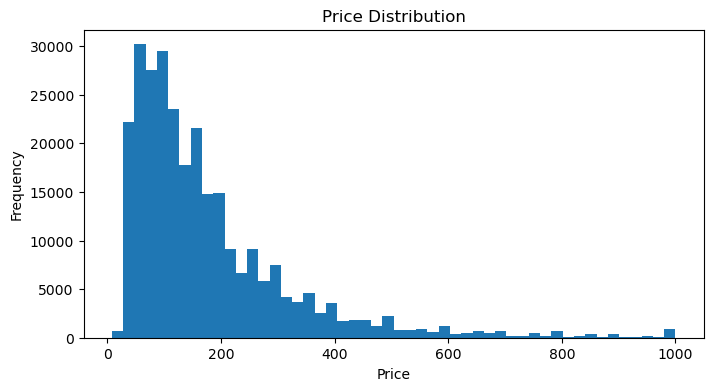

In [15]:
# 6. 可视化：价格分布与异常值
#最好用log y做模型 pre的时候取对数 还原成y
plt.figure(figsize=(8, 4))
#plt.hist(df['log_price'], bins=50)
plt.hist(df['price'], bins=50)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

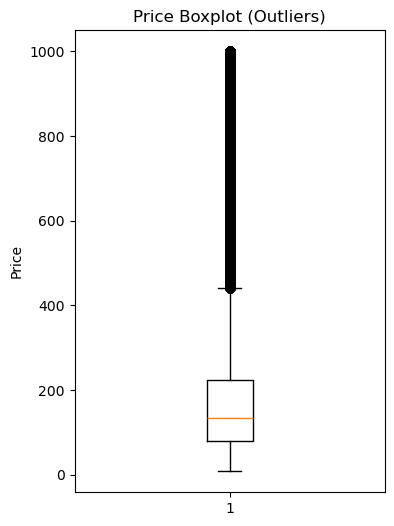

In [16]:
plt.figure(figsize=(4, 6))
plt.boxplot(df['price'])
plt.title('Price Boxplot (Outliers)')
plt.ylabel('Price')
plt.show()
#有很多值在400-800
#尝试violin chart

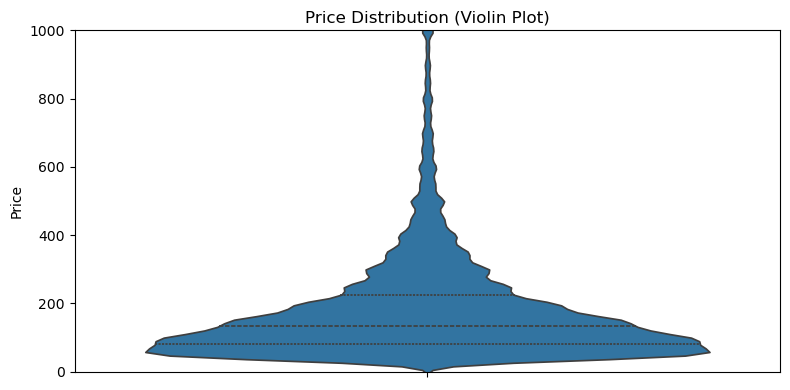

In [17]:
import seaborn as sns
plt.figure(figsize=(8, 4))
sns.violinplot(y=df['price'], inner='quartile')
plt.title('Price Distribution (Violin Plot)')
plt.ylabel('Price')
plt.xlabel('')
plt.ylim(0, 1000)
plt.tight_layout()
plt.show()

# section02 统计分析和数据可视化

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from zipfile import ZipFile
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [21]:
with ZipFile('airbnb.zip') as z:
    fname = [f for f in z.namelist() if '2024_11' in f][0]
    df = pd.read_csv(z.open(fname))

df = df[(df['price'] > 0) & (df['price'] <= 1000)]


pop_counts = df['room_type'].value_counts()
print("本月最受欢迎的房间类型：")
print(pop_counts)

本月最受欢迎的房间类型：
room_type
Entire home/apt    12335
Private room        9538
Hotel room           340
Shared room          244
Name: count, dtype: int64


In [22]:
avg_price = df.groupby('room_type')['price'].mean().sort_values(ascending=False)
print("\n本月最昂贵的房间类型（平均价格）：")
print(avg_price)


本月最昂贵的房间类型（平均价格）：
room_type
Hotel room         391.705882
Entire home/apt    243.726064
Private room       118.058503
Shared room         96.213115
Name: price, dtype: float64


In [23]:
# 房源最多的 neighbourhood 和 neighbourhood_group
nb_counts = df['neighbourhood'].value_counts()
ng_counts = df['neighbourhood_group'].value_counts()
print("\n房源最多的 neighbourhood（前10）：")
print(nb_counts.head(10))
print("\n房源最多的 neighbourhood_group：")
print(ng_counts)


房源最多的 neighbourhood（前10）：
neighbourhood
Bedford-Stuyvesant    1694
Midtown               1392
Hell's Kitchen         997
Upper East Side        983
Williamsburg           889
Harlem                 886
Upper West Side        873
Bushwick               835
Crown Heights          727
Chelsea                504
Name: count, dtype: int64

房源最多的 neighbourhood_group：
neighbourhood_group
Manhattan        9690
Brooklyn         7953
Queens           3551
Bronx             949
Staten Island     314
Name: count, dtype: int64


room_type           Entire home/apt  Hotel room  Private room  Shared room
neighbourhood                                                             
Bedford-Stuyvesant              686           0           976           32
Bushwick                        272           0           539           24
Chelsea                         389           0           114            1
Crown Heights                   356           0           363            8
Harlem                          287           1           587           11
Hell's Kitchen                  705           6           282            4
Midtown                         903         113           372            4
Upper East Side                 847          17           115            4
Upper West Side                 578          38           247           10
Williamsburg                    478          11           394            6


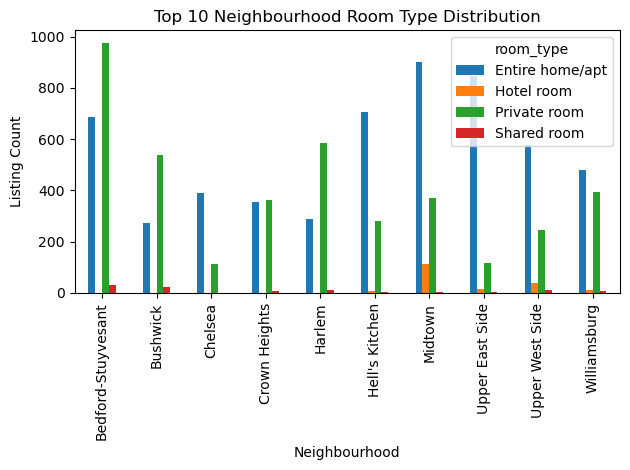

In [24]:
# 不同房间类型在前10个 neighbourhood分布
top10_neighbourhoods = nb_counts.head(10).index.tolist()
df_top10 = df[df['neighbourhood'].isin(top10_neighbourhoods)]
counts = df_top10.groupby(['neighbourhood', 'room_type'])['id'].count()
pivot = counts.unstack(fill_value=0)
print(pivot)


pivot.plot(kind='bar')
plt.xlabel('Neighbourhood')
plt.ylabel('Listing Count')
plt.title('Top 10 Neighbourhood Room Type Distribution')
plt.tight_layout()
plt.show()
#最好是拿地图出来，在里面放出来数据或者进行比较
#根据经纬度 直接把图画出来
#根据经纬度 把真实的地图画出来

In [30]:
# pip install contextily

In [32]:
# pip install geopandas

In [27]:
# import pandas as pd
# import geopandas as gpd
# import matplotlib.pyplot as plt
# import contextily as ctx

# # 读取 airbnb_2024_11 数据
# with zipfile.ZipFile("airbnb.zip") as z:
#     fname = [f for f in z.namelist() if "2024_11" in f][0]
#     df = pd.read_csv(z.open(fname))

# # 获取前10个 neighbourhood
# top10_neighbourhoods = df['neighbourhood'].value_counts().head(10).index.tolist()
# df_top10 = df[df['neighbourhood'].isin(top10_neighbourhoods)]

# # 创建 GeoDataFrame
# gdf = gpd.GeoDataFrame(df_top10, geometry=gpd.points_from_xy(df_top10['longitude'], df_top10['latitude']), crs="EPSG:4326")
# gdf = gdf.to_crs(epsg=3857)  # 转为墨卡托坐标用于叠加地图

# # 绘图
# fig, ax = plt.subplots(figsize=(12, 8))
# for room_type, sub in gdf.groupby("room_type"):
#     sub.plot(ax=ax, markersize=10, alpha=0.6, label=room_type)

# ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
# ax.set_title("Room Type Distribution in Top 10 Neighbourhoods (Nov 2024)")
# plt.legend()
# plt.axis("off")
# plt.tight_layout()
# plt.show()


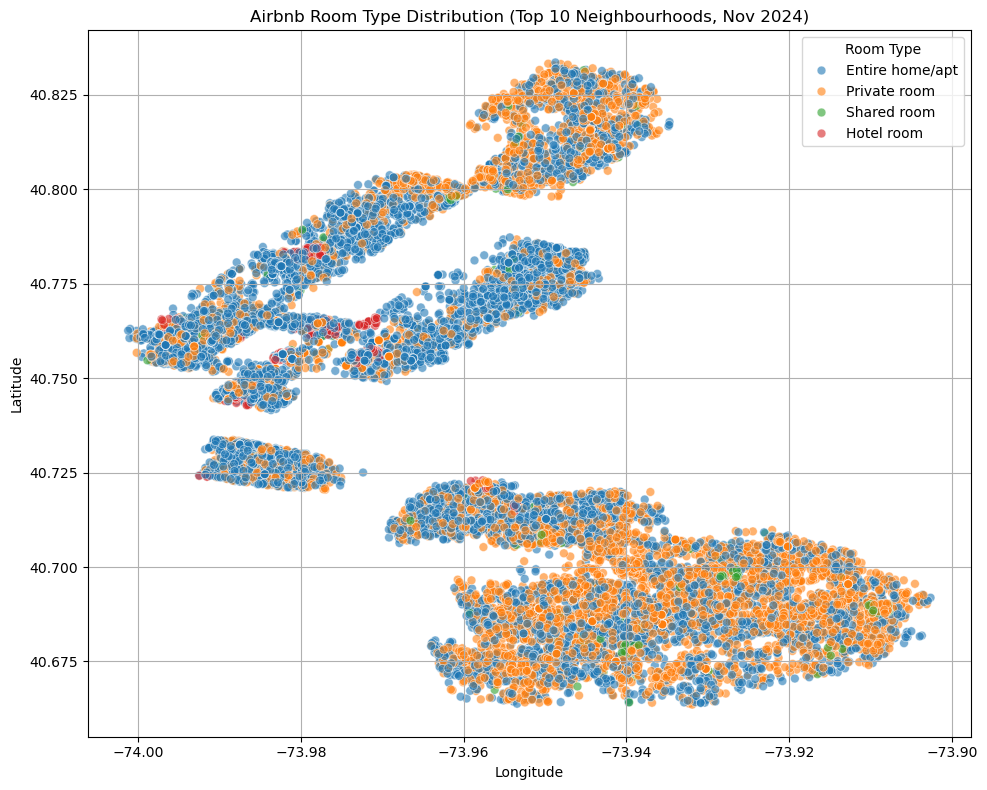

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

# 读取 2024_11 数据
with zipfile.ZipFile("airbnb.zip") as z:
    fname = [f for f in z.namelist() if "2024_11" in f][0]
    df = pd.read_csv(z.open(fname))

# 获取前10个最热门的 neighbourhood
top10_neigh = df['neighbourhood'].value_counts().head(10).index.tolist()
df_top10 = df[df['neighbourhood'].isin(top10_neigh)]

# 绘图：经纬度散点图（按房型分类）
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_top10,
    x='longitude',
    y='latitude',
    hue='room_type',
    alpha=0.6,
    s=40
)

plt.title("Airbnb Room Type Distribution (Top 10 Neighbourhoods, Nov 2024)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title='Room Type')
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
# # 房价预测 线性回归
# features = ['minimum_nights', 'number_of_reviews', 'reviews_per_month','calculated_host_listings_count', 'availability_365']
# X = df[features].fillna(0)
# y = df['price']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = LinearRegression()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# r2 = r2_score(y_test, y_pred)
# coeffs = pd.Series(model.coef_, index=features)

# print(f"\n预测模型 R2 分数：{r2:.3f}")
# print("\n各特征系数：")
# print(coeffs)

#####统计分析与数据可视化

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

with ZipFile('airbnb.zip') as z:
    files = [f for f in z.namelist() if '2024_' in f and f.endswith('.csv')]
    df_list = []
    for f in files:
        month = int(f.split('_')[-1].split('.')[0])
        df_temp = pd.read_csv(z.open(f))
        df_temp['month'] = month
        df_list.append(df_temp)
df_all = pd.concat(df_list, ignore_index=True)

In [36]:
df_all = df_all[(df_all['price'] > 0) & (df_all['price'] <= 1000)]

features = [
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]
#需要包含地区信息
#转换成dummy variable 加一些特征 转换成0，1 get_dummy

In [37]:
print("各月线性回归模型 R² 分数：")
for m in sorted(df_all['month'].unique()):
    dfm = df_all[df_all['month'] == m]
    X = dfm[features].fillna(0)
    y = dfm['price']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"Month {m:02d}: R² = {r2:.3f}")

各月线性回归模型 R² 分数：
Month 02: R² = 0.019
Month 03: R² = 0.028
Month 04: R² = 0.030
Month 05: R² = 0.043
Month 06: R² = 0.037
Month 07: R² = 0.038
Month 08: R² = 0.050
Month 09: R² = 0.060
Month 10: R² = 0.088
Month 11: R² = 0.041


In [38]:
# # 2024 年各 neighbourhood_group 月均价趋势
# #legend得放出去 不能挡着图
# trend = df_all.groupby(['month', 'neighbourhood_group'])['price'].mean().reset_index()
# pivot_trend = trend.pivot(index='month', columns='neighbourhood_group', values='price')
# pivot_trend.plot(figsize=(8, 4))
# plt.xlabel('Month')
# plt.ylabel('Avg Price (SGD)')
# plt.title('2024 Avg Price Trend by Neighbourhood Group')
# plt.xticks(range(1, 13))
# plt.legend(title='Neighbourhood Group')
# plt.show()

In [41]:
# import matplotlib.pyplot as plt

# pivot_trend.plot(figsize=(12, 6))
# plt.xlabel('Month')
# plt.ylabel('Avg Price (SGD)')
# plt.title('2024 Avg Price Trend by Neighbourhood Group')
# plt.xticks(range(1, 13))

# plt.legend(title='Neighbourhood Group', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

In [42]:
#预测 11 月
train = df_all[(df_all['month'] >= 2) & (df_all['month'] <= 10)]
test = df_all[df_all['month'] == 11]
X_train = train[features].fillna(0)
y_train = train['price']
X_test = test[features].fillna(0)
y_test = test['price']
model_nov = LinearRegression()
model_nov.fit(X_train, y_train)
y_pred_nov = model_nov.predict(X_test)
r2_nov = r2_score(y_test, y_pred_nov)
print(f"\nRetrained on Feb–Oct, R² on Nov = {r2_nov:.3f}")


Retrained on Feb–Oct, R² on Nov = 0.042


第四部分

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

In [44]:
from zipfile import ZipFile

zip_path = "airbnb.zip"

with ZipFile(zip_path) as z:
    files_2024 = [f for f in z.namelist() if '2024_' in f and f.endswith('.csv')]
    df_2024_list = []
    for f in files_2024:
        month = int(f.split('_')[-1].split('.')[0])
        df_temp = pd.read_csv(z.open(f))
        df_temp['month'] = month
        df_2024_list.append(df_temp)
    df_2024_all = pd.concat(df_2024_list, ignore_index=True)
    df_2024_all['year'] = 2024


    file_2019 = [f for f in z.namelist() if '2019_00' in f][0]
    df_2019 = pd.read_csv(z.open(file_2019))
    df_2019['month'] = pd.to_datetime(df_2019['last_review'], errors='coerce').dt.month.fillna(0).astype(int)
    df_2019['year'] = 2019

df_compare = pd.concat([df_2019, df_2024_all], ignore_index=True)
df_compare = df_compare[df_compare['price'].notnull() & (df_compare['price'] > 0)]
df_compare['reviews_per_month'] = df_compare['reviews_per_month'].fillna(0)
df_compare = df_compare[['year', 'month', 'room_type', 'neighbourhood_group', 'price']]


df_compare.head()


,year,month,room_type,neighbourhood_group,price
0,2019,10,Private room,Brooklyn,149.0
1,2019,5,Entire home/apt,Manhattan,225.0
2,2019,0,Private room,Manhattan,150.0
3,2019,7,Entire home/apt,Brooklyn,89.0
4,2019,11,Entire home/apt,Manhattan,80.0


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# 2019 平均房价趋势
df_2019_filtered = df_compare[(df_compare['year'] == 2019) & (df_compare['month'] > 0)]
avg_price_2019 = df_2019_filtered.groupby(['month', 'neighbourhood_group'])['price'].mean().reset_index()

In [46]:
# 房型结构占比对比
room_type_dist = df_compare.groupby(['year', 'room_type'])['price'].count().reset_index(name='count')
room_type_dist['percentage'] = room_type_dist.groupby('year')['count'].transform(lambda x: x / x.sum() * 100)

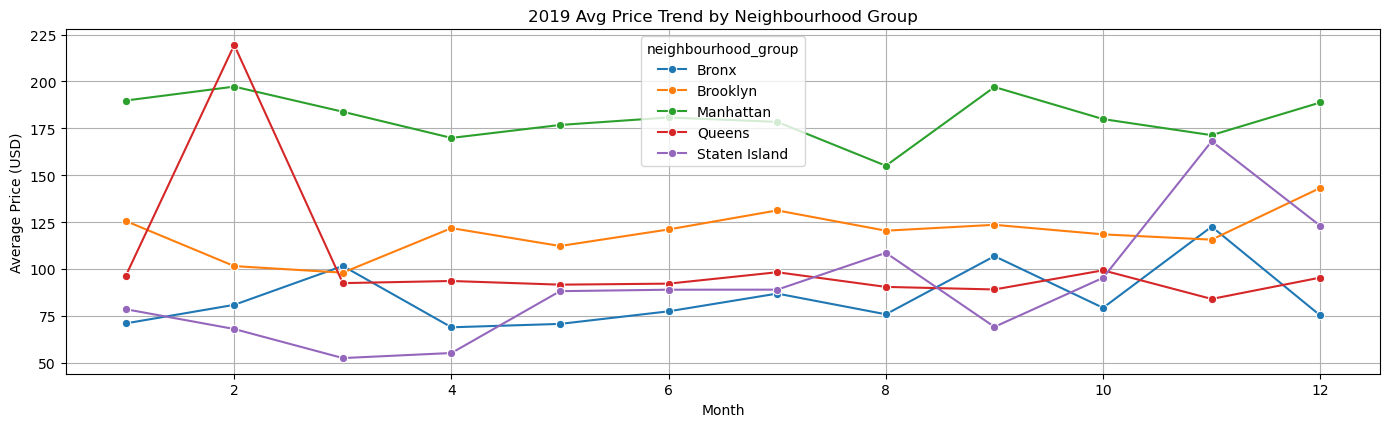

In [47]:
# 房价对比箱型图
df_price_compare = df_compare[df_compare['month'] > 0]

# 可视化
plt.figure(figsize=(14, 12))
# 2019年按区域平均价格趋势图
plt.subplot(3, 1, 1)
sns.lineplot(data=avg_price_2019, x='month', y='price', hue='neighbourhood_group', marker='o')
plt.title("2019 Avg Price Trend by Neighbourhood Group")
plt.xlabel("Month")
plt.ylabel("Average Price (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()

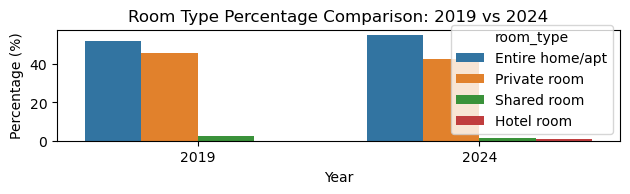

In [48]:
# 房型结构占比对比
#年份对比 把两个蓝条放一起 看百分比最好的方式 是变成 stack bar chart
plt.subplot(3, 1, 2)
sns.barplot(data=room_type_dist, x='year', y='percentage', hue='room_type')
plt.title("Room Type Percentage Comparison: 2019 vs 2024")
plt.ylabel("Percentage (%)")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

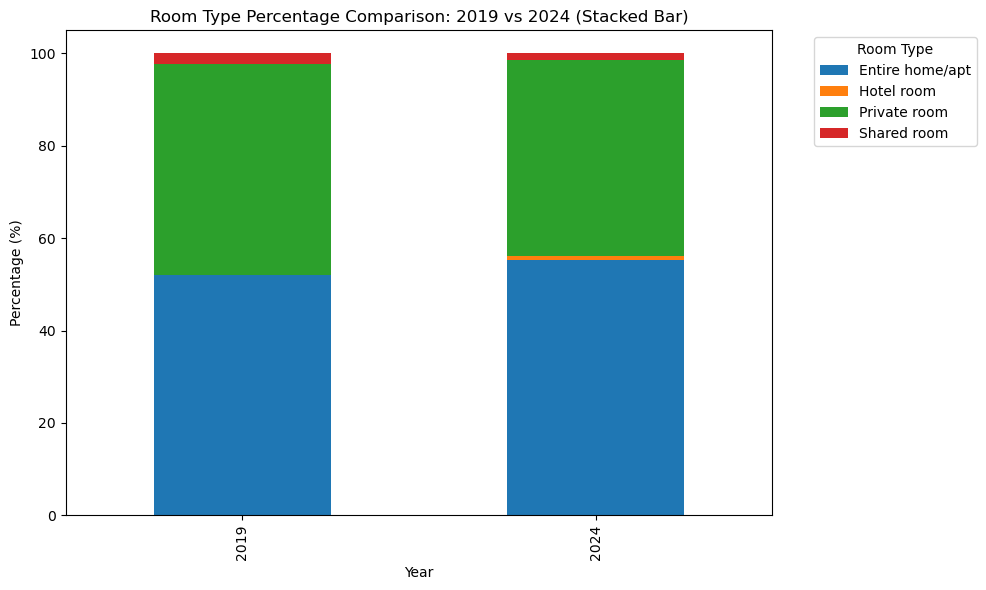

In [49]:
# 将数据透视成适合堆叠的格式
pivot_room_type = room_type_dist.pivot(index='year', columns='room_type', values='percentage').fillna(0)

# 绘制堆叠柱状图
pivot_room_type.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title("Room Type Percentage Comparison: 2019 vs 2024 (Stacked Bar)")
plt.ylabel("Percentage (%)")
plt.xlabel("Year")
plt.legend(title='Room Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

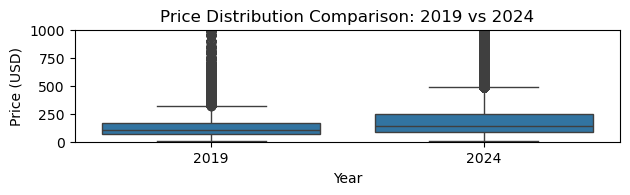

In [50]:
# 图 3: 房价分布对比
#最好不用箱型图 用点图 柱状图
plt.subplot(3, 1, 3)
sns.boxplot(data=df_price_compare, x='year', y='price')
plt.title("Price Distribution Comparison: 2019 vs 2024")
plt.ylabel("Price (USD)")
plt.xlabel("Year")
plt.ylim(0, 1000)
plt.tight_layout()
plt.show()

C:\Users\Candy\AppData\Local\Temp\ipykernel_19012\594905789.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_price_compare, x='year', y='price', palette="Set2")  # 添加配色


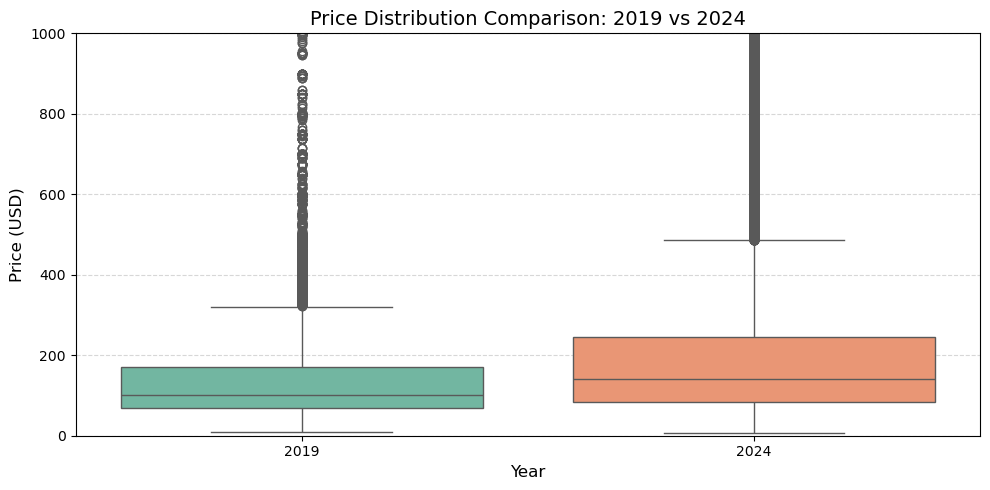

In [51]:
plt.figure(figsize=(10, 5))  # 适当扩大尺寸
sns.boxplot(data=df_price_compare, x='year', y='price', palette="Set2")  # 添加配色
plt.title("Price Distribution Comparison: 2019 vs 2024", fontsize=14)
plt.ylabel("Price (USD)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylim(0, 1000)  # 限制异常值拉伸
plt.grid(axis='y', linestyle='--', alpha=0.5)  # 加一点辅助线
plt.tight_layout()
plt.show()

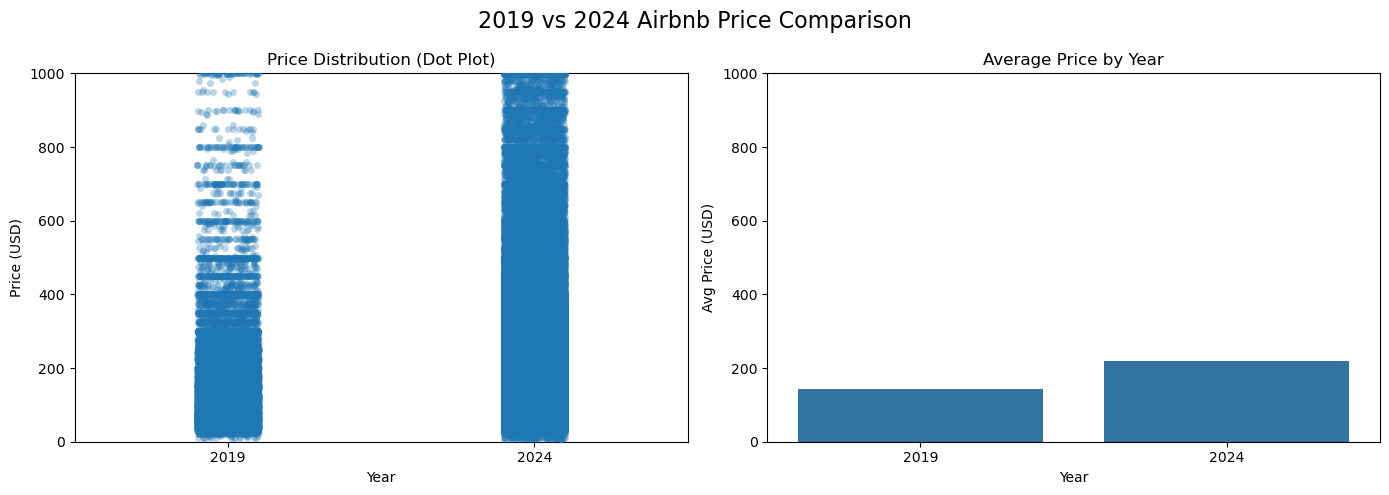

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# 创建子图区域
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# 1️⃣ 点图：每个房源价格点
sns.stripplot(data=df_price_compare, x='year', y='price', alpha=0.3, jitter=True, ax=axs[0])
axs[0].set_title("Price Distribution (Dot Plot)")
axs[0].set_ylabel("Price (USD)")
axs[0].set_xlabel("Year")
axs[0].set_ylim(0, 1000)

# 2️⃣ 平均柱状图
avg_price = df_price_compare.groupby('year')['price'].mean().reset_index()
sns.barplot(data=avg_price, x='year', y='price', ax=axs[1])
axs[1].set_title("Average Price by Year")
axs[1].set_ylabel("Avg Price (USD)")
axs[1].set_xlabel("Year")
axs[1].set_ylim(0, 1000)

plt.suptitle("2019 vs 2024 Airbnb Price Comparison", fontsize=16)
plt.tight_layout()
plt.show()

In [53]:
#图 需要控制图片的尺寸 适当加上结论